In [4]:
import create_data
import kmeans
import voltage
import os
import importlib
import time
import bpf
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [5]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)
importlib.reload(bpf)

<module 'bpf' from '/Users/yoavfreund/projects/VoltageDimentionalReduction/code/bpf.py'>

In [6]:
import kagglehub

path = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")

print(path)

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|████████████████████████████████████████████████████████████| 386M/386M [00:07<00:00, 51.5MB/s]

Extracting files...


/Users/yoavfreund/.cache/kagglehub/datasets/thanakomsn/glove6b300dtxt/versions/1


In [8]:
def load_glove_vectors(filepath, max_words=100000):
    word2vec = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_words:
                break
            parts = line.strip().split()
            word = parts[0]
            vector = list(map(float, parts[1:]))
            word2vec[word] = vector
    return word2vec

# Example
glove_path = path + "/glove.6B.300d.txt"  # or 300d
glove_vectors = load_glove_vectors(glove_path, max_words=1000)

In [9]:
words = list(glove_vectors.keys())
vectors = [glove_vectors[word] for word in words]
data = create_data.Data(vectors)

In [10]:
import random

# landmark_words = [words[int(random.random() * len(vectors))] for x in range(3)]
landmark_words = ["world", "country", "china"]

landmarks = []
for word in landmark_words:
    landmarks.append(voltage.Landmark(words.index(word), 1))

print(len(data))
print([l.index for l in landmarks])
print(landmark_words)

1000
[85, 123, 132]
['world', 'country', 'china']


In [11]:
cs = []
pgs = []

param_finder = bpf.BestParameterFinder()
param_finder.setKernelParameter(2e7)
# param_finder.setResistanceToGround(0.1)

for landmark in landmarks:
     c, p_g = param_finder.bestParameterFinder([landmark], data, minBound=-50, maxBound=20, granularity=20, epsilon=0.01, approx=100)
     print(c, p_g)
     cs.append(c)
     pgs.append(p_g)

19999999.999999978 1.1099189036438807e-21
19999999.999999978 1.1099189036438807e-21
19999999.999999978 1.1099189036438807e-21


In [12]:
voltages = []

for index in range(0, len(landmarks)):
    problem = voltage.Problem(data)
    problem.setKernel(problem.gaussiankernel)
    problem.setWeights(cs[index])
    problem.addLandmark(landmarks[index])
    problem.addUniversalGround(pgs[index])
    voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=100))

(1000, 3)
(1000, 2)


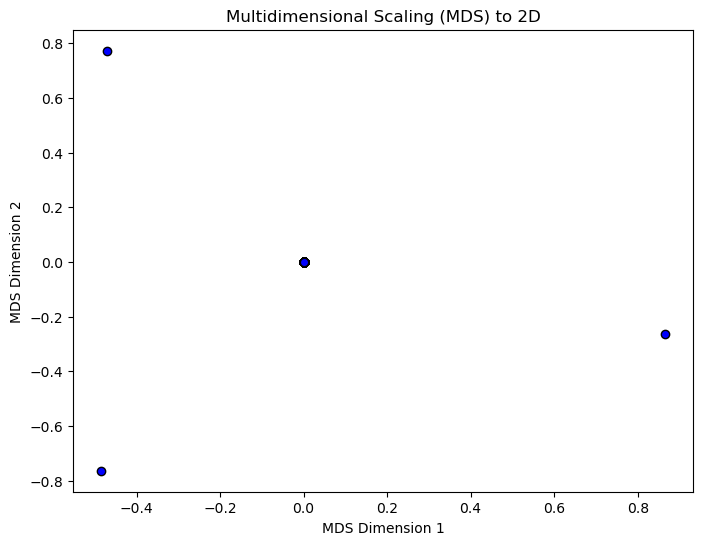

<Figure size 640x480 with 0 Axes>

In [13]:
points = np.array(list(map(list, zip(*voltages))))

print(points.shape)

# MDS
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

print(transformed_points.shape)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Multidimensional Scaling (MDS) to 2D")

# plt.savefig(fileStarter + "_MDS.png")
plt.show()
plt.clf()

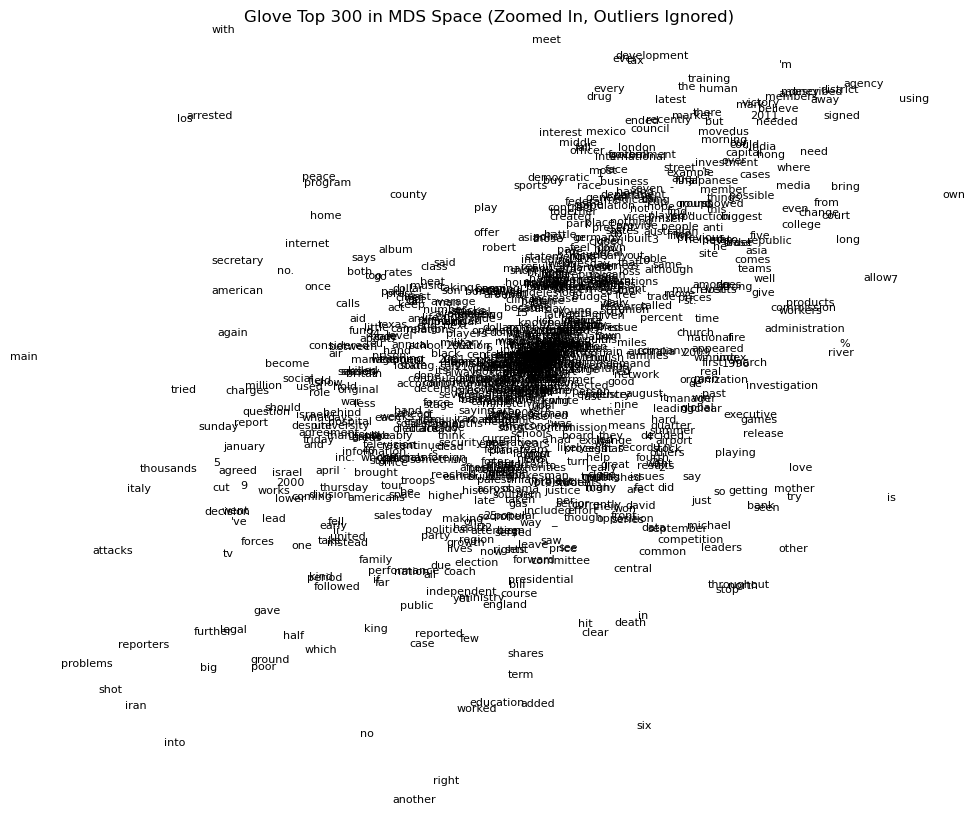

In [14]:
# Step 1: Calculate distances from the mean (or median) of all points
center = np.mean(transformed_points, axis=0)
distances = np.linalg.norm(transformed_points - center, axis=1)

# Step 2: Find the indices of the 10 most distant points
outlier_indices = np.argsort(distances)[-10:]

# Step 3: Get the mask of inliers (non-outliers)
mask = np.ones(len(transformed_points), dtype=bool)
mask[outlier_indices] = False

# Step 4: Get the non-outlier (central cluster) points
inlier_points = transformed_points[mask]

# Plot with zoom-in
fig, ax = plt.subplots(figsize=(12, 10))
for i in np.where(mask)[0]:
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(words[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

# Set axis limits based on inlier points
ax.set_xlim(inlier_points[:, 0].min(), inlier_points[:, 0].max())
ax.set_ylim(inlier_points[:, 1].min(), inlier_points[:, 1].max())

plt.axis('off')
plt.title("Glove Top 300 in MDS Space (Zoomed In, Outliers Ignored)")
plt.show()